# Simulation Run Log Analysis and Visualization for AWS DeepRacer

This notebook walks through how you can analyze and debug using the AWS DeepRacer Simulation logs 

```
1. Tools to find best iteration of your model
2. Visualize reward distribution on the track
  2.1 Visualize reward heatmap per episode or iteration
3. Identify hotspots on the track for your model
4. Understand probability distributions on simulated images
5. Evaluation run analysis - plot lap speed heatmap
```

## Requirements

boto3 >= 1.9.133  ; configure your aws cli and/or boto credentials file

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

import track_utils as tu
import log_analysis as la
import cw_utils as cw

# Make sure your boto version is >= '1.9.133'
cw.boto3.__version__

'1.9.175'

In [2]:
# reload log_analysis and the rest of stuff here if needed
# (handy for code updates in utils, doesn't break anything if no changes)
import importlib
importlib.reload(la)
importlib.reload(cw)
importlib.reload(tu)

<module 'track_utils' from '/home/tptak/dev/aws-deepracer-workshops/log-analysis/track_utils.py'>

## Load waypoints for the track you want to run analysis on

Tracks Available:

In [3]:
!ls tracks/

AWS_track.npy	  London_Loop_Train.npy  Straight_track.npy
Bowtie_track.npy  Oval_track.npy	 Tokyo_Training_track.npy
H_track.npy	  reinvent_base.npy	 Virtual_May19_Train_track.npy


Loaded 71 waypoints


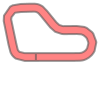

In [4]:
l_center_line, l_inner_border, l_outer_border, road_poly = tu.load_track("reinvent_base")

road_poly

## Load all evaluation data



In [5]:
stream_name = 'sim-sample' ## CHANGE This to your simulation application ID
fname = 'logs/deepracer-%s.log' %stream_name


### Download the desired log file given the simulation ID 


If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: 
https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

_Use `force=True` to download again_

In [6]:
#add force=True if you downloaded the file once but want to repeat
cw.download_log(fname, stream_prefix=stream_name)

!tail -n 3 $fname

Log file exists, use force=True to download again
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
SIM_TRACE_LOG:799,112,1.6637,4.4457,3.0636,0.26,2.50,6,1.0000,False,True,72.1366,49,17.67,1555554451.2382815
SIM_TRACE_LOG:799,113,1.5520,4.4493,3.0941,0.52,5.00,9,1.0000,False,True,72.7582,49,17.67,1555554451.3647106


## Load the trace training log

In [7]:
data = la.load_data(fname)
df = la.convert_to_pandas(data)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# la.normalize_rewards(df)

Below you can uncomment the new_reward and apply it to your simulation data. Bear in mind there is a problem of rounded values in the log and because I am using those to recreate params, there will be some loss of precision.

Also remember that I haven't prepared all of the params just yet. I didn't need all of them for the previous race so I may be adding them in the near future. See new_reward in log_analysis.py to check what you can add and use.

Number of episodes =  799


/home/tptak/dev/aws-deepracer-workshops/venv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Number of iterations =  31


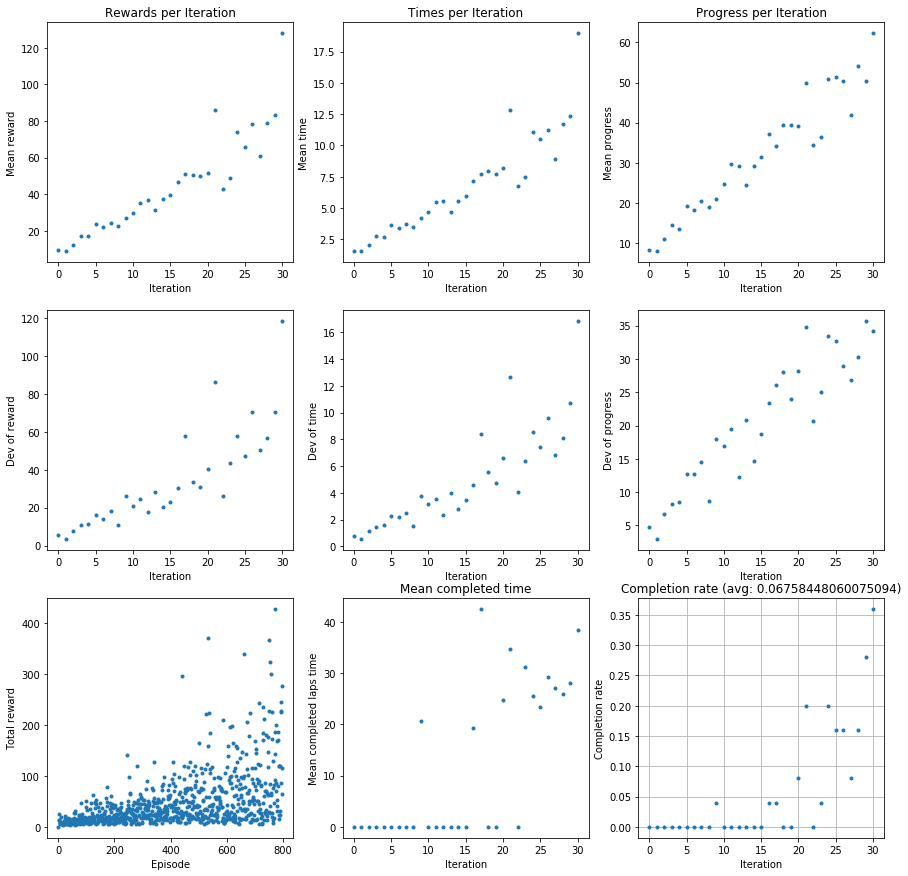

In [8]:
EPISODES_PER_ITERATION = 25


la.analyze_training_progress(df, EPISODES_PER_ITERATION)

Note the first line below: it takes a reward class from log-analysis/rewards, imports, instantiates and recalculates for the log. This lets you do some testing before you start training and rule out some obvious things.

Just remember: not all params are provided, you are free to implement them and raise a Pull Request for log_analysis.df_to_params method.

Wrap your reward function like in the sample one below.

Final warning: there is a loss of precision in the logs and also potentially potential bugs. If you find any, please fix, please report.

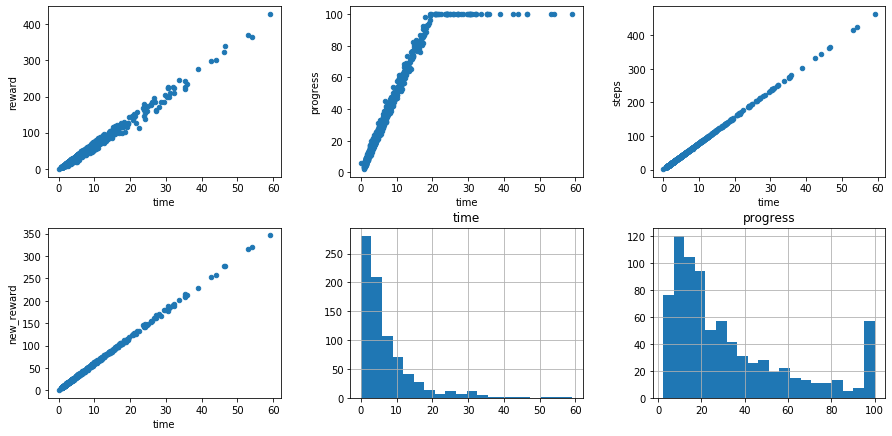

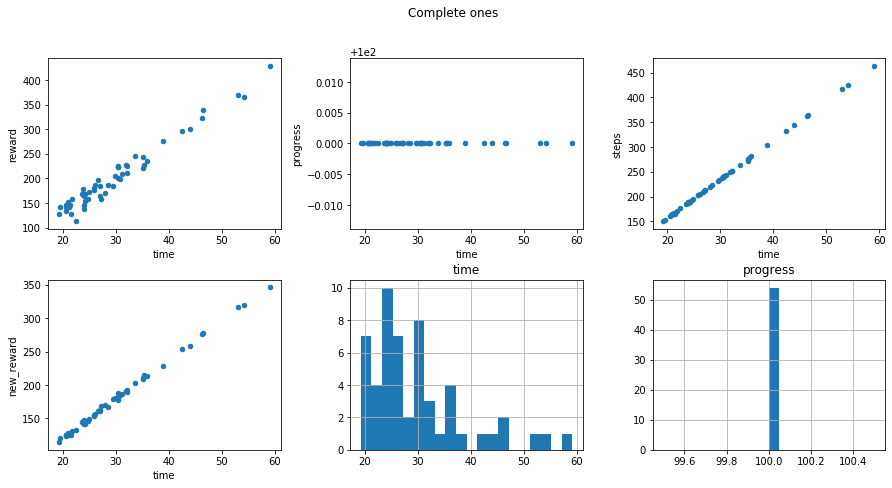

In [9]:
la.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

simulation_agg = la.simulation_agg(df)

complete_ones = simulation_agg[simulation_agg['progress']==100]

# This gives the warning about ptp method deprecation. The code looks as if np.ptp was used, I don't know how to fix it.
la.scatter_aggregates(simulation_agg)
la.scatter_aggregates(complete_ones, "Complete ones")

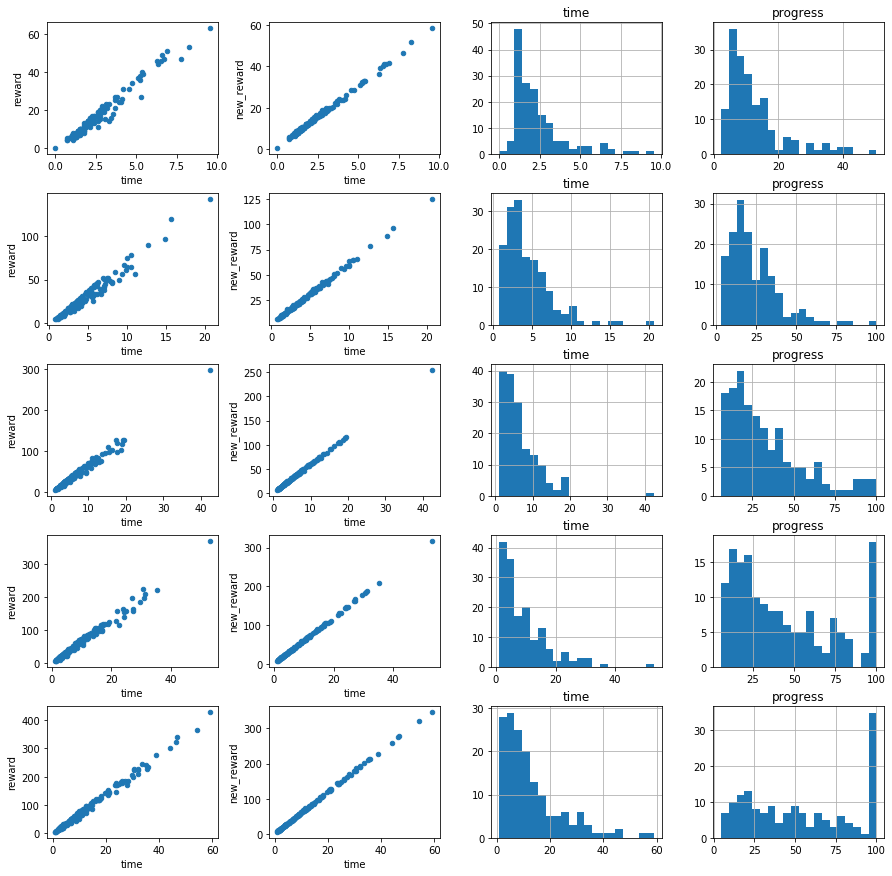

In [10]:
la.analyze_categories(simulation_agg)



The calls below are useful when you want to look at some values largest or smallest. You can then take the episode number and scatter it below.

In [11]:
# this is useful if you struggle to get a complete lap
simulation_agg.nlargest(10, 'new_reward')

,iteration,episode,steps,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile
771,39,771,463,100.0,59.128915,346.1,2.931034,428.035,59.128915,428.035,5th
750,38,750,424,100.0,54.151004,320.3,3.152941,366.058,54.151004,366.058,5th
534,27,534,416,100.0,53.062871,316.2,2.973621,370.046,53.062871,370.046,4th
663,34,663,365,100.0,46.550202,278.4,2.943989,339.026,46.550202,339.026,5th
753,38,753,362,100.0,46.345598,276.9,3.071625,323.039,46.345598,323.039,5th
758,38,758,344,100.0,44.017881,258.3,3.000000,301.043,44.017881,301.043,5th
439,22,439,333,100.0,42.504236,253.3,2.986527,297.036,42.504236,297.036,3rd
796,40,796,304,100.0,38.883088,227.9,3.024590,277.027,38.883088,277.027,5th
752,38,752,277,100.0,35.355489,214.4,3.075540,227.050,35.355489,227.050,5th
729,37,729,281,100.0,35.865736,213.3,3.067376,235.046,35.865736,235.046,5th


In [12]:
# fastest complete laps
complete_ones.nsmallest(5, 'time')

,iteration,episode,steps,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile
408,21,408,151,100.0,19.257555,114.5,2.976974,128.023,19.257555,128.023,3rd
668,34,668,153,100.0,19.560122,120.1,2.954545,143.010,19.560122,143.010,5th
653,33,653,161,100.0,20.583288,124.5,3.055556,147.014,20.583288,147.014,5th
648,33,648,162,100.0,20.670356,123.4,3.190184,135.027,20.670356,135.027,5th
243,13,243,162,100.0,20.680382,124.9,3.297546,142.020,20.680382,142.020,2nd


In [13]:
# best rewards in completed laps
complete_ones.nlargest(5, 'reward')

,iteration,episode,steps,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile
771,39,771,463,100.0,59.128915,346.1,2.931034,428.035,59.128915,428.035,5th
534,27,534,416,100.0,53.062871,316.2,2.973621,370.046,53.062871,370.046,4th
750,38,750,424,100.0,54.151004,320.3,3.152941,366.058,54.151004,366.058,5th
663,34,663,365,100.0,46.550202,278.4,2.943989,339.026,46.550202,339.026,5th
753,38,753,362,100.0,46.345598,276.9,3.071625,323.039,46.345598,323.039,5th


In [14]:
# best rewards in completed laps
complete_ones.nlargest(5, 'new_reward')

,iteration,episode,steps,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile
771,39,771,463,100.0,59.128915,346.1,2.931034,428.035,59.128915,428.035,5th
750,38,750,424,100.0,54.151004,320.3,3.152941,366.058,54.151004,366.058,5th
534,27,534,416,100.0,53.062871,316.2,2.973621,370.046,53.062871,370.046,4th
663,34,663,365,100.0,46.550202,278.4,2.943989,339.026,46.550202,339.026,5th
753,38,753,362,100.0,46.345598,276.9,3.071625,323.039,46.345598,323.039,5th


In [15]:
# this is useful if you struggle to get a complete lap
simulation_agg.nlargest(5, 'progress')

,iteration,episode,steps,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile
243,13,243,162,100.0,20.680382,124.9,3.297546,142.020,20.680382,142.020,2nd
408,21,408,151,100.0,19.257555,114.5,2.976974,128.023,19.257555,128.023,3rd
439,22,439,333,100.0,42.504236,253.3,2.986527,297.036,42.504236,297.036,3rd
502,26,502,213,100.0,27.122768,161.5,2.978972,164.049,27.122768,164.049,4th
524,27,524,176,100.0,22.464986,132.3,3.036723,114.062,22.464986,114.062,4th


In [16]:
# list all entries aggregated per episode. Handy for comparing the outcomes for reward and new_reward,
# but for not much else.
simulation_agg.head()

,iteration,episode,steps,progress,time,new_reward,throttle,reward,time_if_complete,reward_if_complete,quintile
0,1,0,2,6.0023,0.000000,0.7,2.500000,0.000,0.000000,0.000000,1st
1,1,1,28,23.5999,3.697678,22.1,3.965517,25.003,15.668196,105.945364,1st
2,1,2,17,10.4036,2.162520,13.8,3.055556,13.004,20.786269,124.995194,1st
3,1,3,16,11.8942,2.035471,13.7,3.382353,14.002,17.113135,117.721242,1st
4,1,4,12,6.7208,1.532167,9.7,2.884615,10.002,22.797387,148.821569,1st


In [17]:
pd.set_option('display.max_rows', 500)

# list all parsed log lines. Handy for comparing the outcomes for reward and new_reward,
# but for not much else.
df[df['episode']==10]

,iteration,episode,steps,x,y,yaw,steer,throttle,action,reward,done,on_track,progress,closest_waypoint,track_len,timestamp,new_reward
136,1,10,0,406.87,340.00,2.2531,0.00,0.0,0.0,1.000,0,True,0.8294,35,17.67,1555547349.448975,1.0
137,1,10,1,405.42,341.53,2.2625,0.52,2.5,8.0,1.000,0,True,0.9483,35,17.67,1555547349.5755942,0.7
138,1,10,2,400.21,346.93,2.2932,-0.26,5.0,3.0,1.000,0,True,1.3717,36,17.67,1555547349.7054713,0.7
139,1,10,3,390.59,356.24,2.3484,0.52,5.0,9.0,1.000,0,True,2.1239,36,17.67,1555547349.8348753,0.7
140,1,10,4,378.56,366.06,2.4313,-0.52,2.5,0.0,1.000,0,True,2.9850,37,17.67,1555547349.9630377,0.7
141,1,10,5,369.34,373.26,2.4618,0.52,2.5,8.0,1.000,0,True,3.6305,37,17.67,1555547350.0892417,0.7
142,1,10,6,361.11,378.73,2.5098,0.00,2.5,4.0,1.000,0,True,4.1643,38,17.67,1555547350.2191164,1.0
143,1,10,7,352.52,383.73,2.5656,0.52,2.5,8.0,1.000,0,True,4.6910,38,17.67,1555547350.351089,0.7
144,1,10,8,343.42,387.83,2.6439,0.26,2.5,6.0,1.000,0,True,5.1960,39,17.67,1555547350.499584,0.7
145,1,10,9,332.90,391.51,2.7328,0.26,2.5,6.0,0.001,0,False,5.8193,39,17.67,1555547350.6270964,0.7


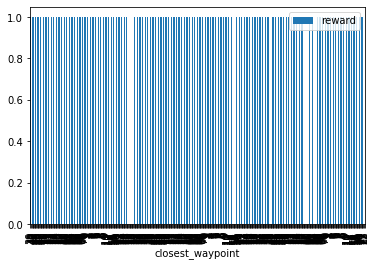

In [18]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==771]
episode[:-1].plot.bar(x='closest_waypoint', y='reward')

## Analyze the reward distribution for your reward function

### Path taken for top reward iterations

NOTE: in a single episode, the car can go around multiple laps, the episode is terminated when car completes 1000 steps

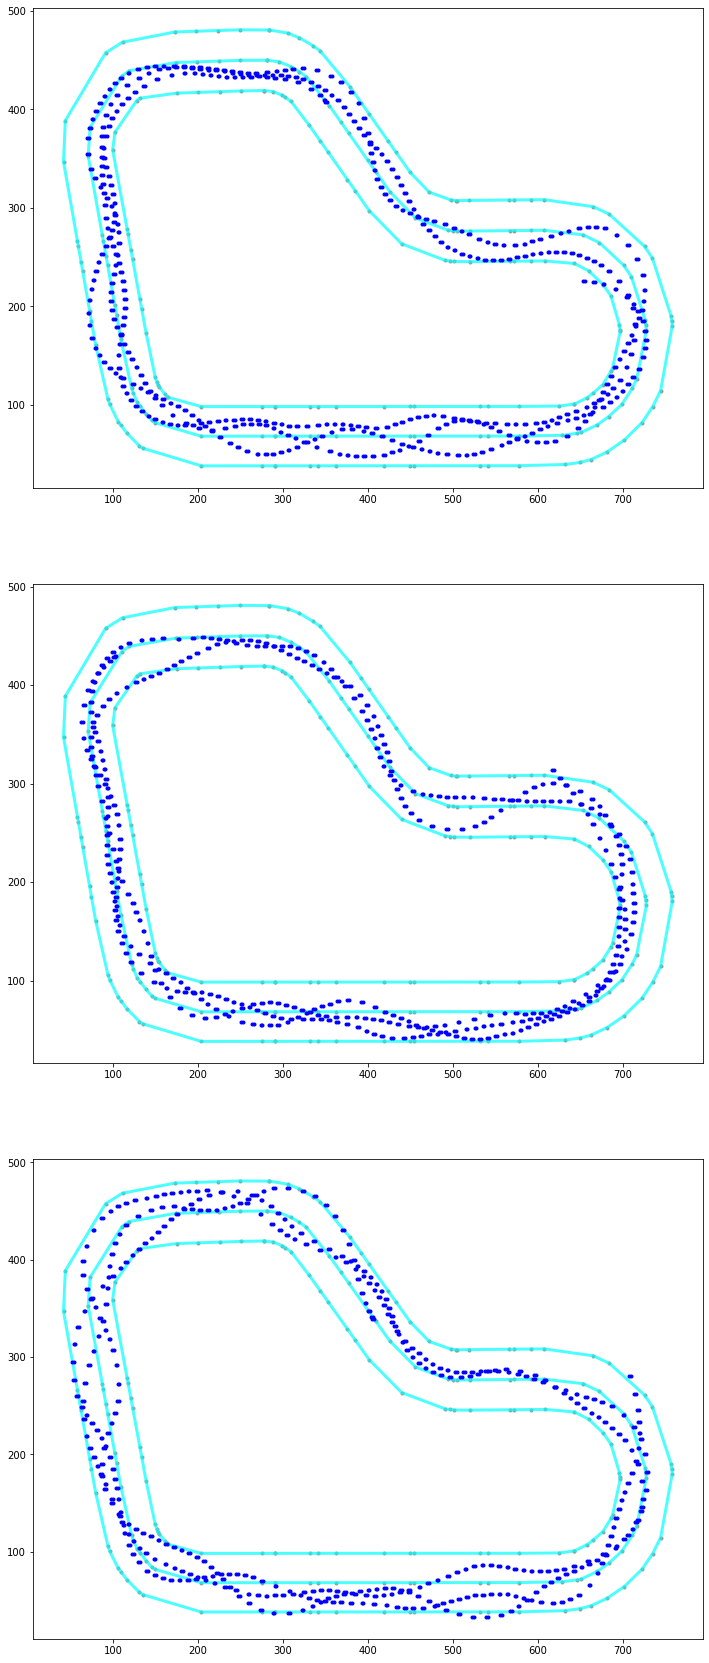

In [19]:
action_map, episode_map, sorted_idx = la.episode_parser(data)    
fig = la.plot_top_laps(sorted_idx[:],  episode_map, l_center_line, l_inner_border, l_outer_border, 3)

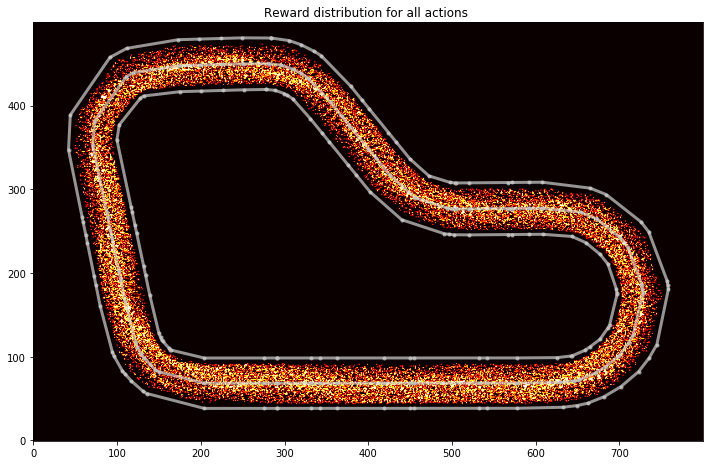

In [20]:
# because Kumo Torakku has negative y values, I shamelessly took
# RichardFan's modificationg for plot_track and refactored it to offer an x_shift and y_shift
# They may not apply to other tracks. You will need to change it in the future. Simply add parameters:
# track_size=(700,1000), y_shift=300
track = la.plot_track(df, l_center_line, l_inner_border, l_outer_border)

plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Plot a particular iteration


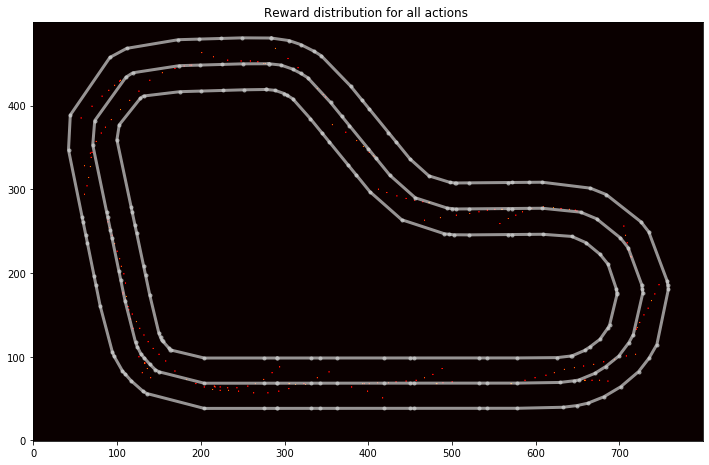

In [21]:
iteration_id = 3
track = la.plot_track(df[df['iteration'] == iteration_id], l_center_line, l_inner_border, l_outer_border)
plt.title("Reward distribution for all actions ")
im = plt.imshow(track, cmap='hot', interpolation='bilinear', origin="lower") 

### Path taken in a particular episode

In [22]:
## Evaluation RUN
def plot_episode_run(df, E, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(12, 16))
    ax = fig.add_subplot(211)
    la.print_border(ax, center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')

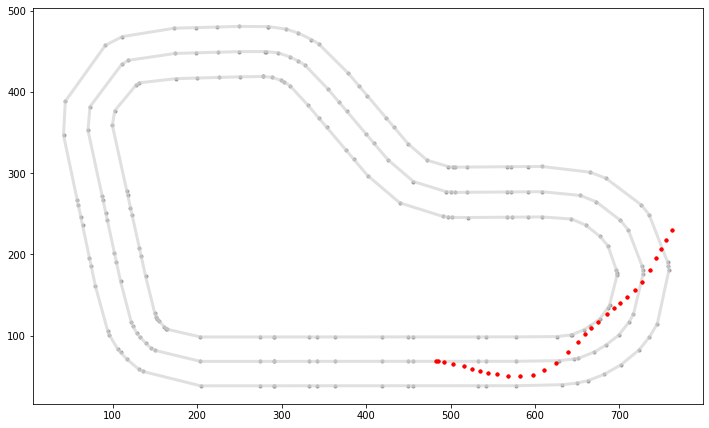

In [23]:
plot_episode_run(df, 122, l_center_line, l_inner_border, l_outer_border) # arbitrary episode

### Path taken in a particular Iteration

/home/tptak/dev/aws-deepracer-workshops/venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.


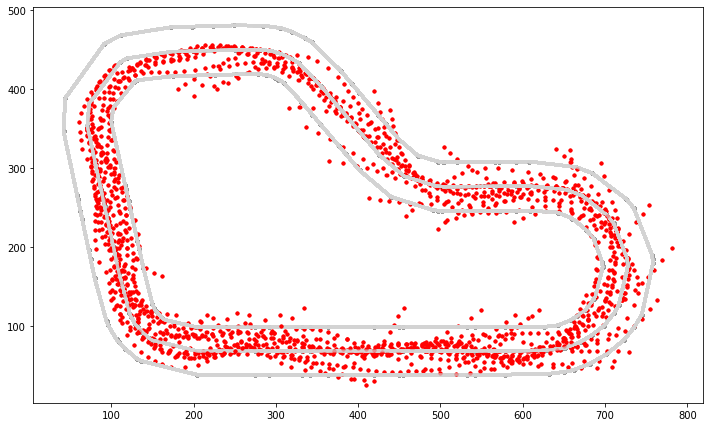

In [24]:
iteration_id = 10
EPISODE_PER_ITER = 40 # TODO this can be fetched from training logs

for i in range((iteration_id-1)*EPISODE_PER_ITER, (iteration_id)*EPISODE_PER_ITER):
    plot_episode_run(df, i, l_center_line, l_inner_border, l_outer_border)

# Bulk training load

This is some slow and heavy stuff in here. You can download all logs (or part of them if you play with `not_older_than` and `older_than` parameters that take a string representation of a date in ISO format, for instance `DD-MM-YYYY` works).

Since it can be a lot of downloading, it is commented out in here.

Files downloaded once will not be downloaded again unless you add `force=True`.

In [ ]:
#logs = cw.download_all_logs('logs/SELECT_YOUR_SUBFOLDER/training/deepracer-', '/aws/robomaker/SimulationJobs')

Load every log from a folder. Every single one. This is a lot of data. If you want to save yourself some time later, below you have code to save and load all that with use of pickle.

In [ ]:
import os

base_folder = 'logs/SELECT_YOUR_SUBFOLDER/training'
df_list = list()
big_training_panda = None
for stream in os.listdir(base_folder):
    data = la.load_data('%s/%s' % (base_folder, stream))
    df = la.convert_to_pandas(data)
    df['stream'] = stream[10:]
    if big_training_panda is not None:
        big_training_panda = big_training_panda.append(df)
    else:
        big_training_panda = df


In [ ]:
# Have I mentioned a lot of data? This stores the data preprocessed for time savings
big_training_panda.to_pickle('bulk_training_set.pickle')

In [ ]:
from pandas import read_pickle

big_training_panda = read_pickle('bulk_training_set.pickle')

In [ ]:
# as usual, handle with care. Towards the end of the London Loop I needed 30-45 minutes to recalculate the reward.
#la.new_reward(big_training_panda, l_center_line, 'reward.reward_sample')

In [ ]:
big_simulation_agg = la.simulation_agg(big_training_panda, 'stream')

big_complete_ones = big_simulation_agg[big_simulation_agg['progress']==100]

In [ ]:
grouped = big_simulation_agg.groupby(['stream'])

for name, group in grouped:
    la.scatter_aggregates(group, title=name)

By the end of London Loop I had so much noise and random tries that wanted to find the most promising version of my model to submit. I used the below piece of code to iterate through all the stream values to detect the one with most promising times histogram. I should've added progress as well since the fastest ones hardly ever completed a lap. I will leave adding that as an exercise for the reader.

In [ ]:
values = []
show = []
show_above = -1
i = 0
for value in big_complete_ones.stream.values:
    if value in values:
        continue
    values.append(value)
    if i in show or i > show_above:
        print(value)
        big_complete_ones[big_complete_ones['stream']==value].hist(column=['time'], bins=20)
    i += 1

In [ ]:
# display loads of everything
big_simulation_agg